In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, random_split
import os
import numpy as np
from PIL import Image
from skimage.metrics import structural_similarity as ssim_skimage
from skimage.metrics import peak_signal_noise_ratio as psnr_skimage

import matplotlib.pyplot as plt
import sys
sys.path.append("../")
from utils.Sen2_RDSR import (
    Sen2RDSR
)
from utils.loaddata import (
    Sentinel2Dataset
)
from utils.loaddatatest import (
    Sentinel2DatasetTest
)


### Optional: Google Colab
If you want to use google colab for free GPU use, you can copy the notebook and files to your google drive (here in directory 'Colab Notebooks'), and mount the drive like this.

In [8]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#cd /content/drive/MyDrive/'Colab Notebooks/Super-Resolution of Sentinel-2 Low Resolution'

In [35]:
# create model
model = Sen2RDSR()
print("Number of model parameters:", sum(p.numel() for p in model.parameters()))




Number of model parameters: 39859464


im10 shape: torch.Size([1, 4, 32, 32])
im20 shape: torch.Size([1, 6, 32, 32])
target20 shape: torch.Size([1, 2, 32, 32])
torch.Size([1, 6, 32, 32]) torch.Size([1, 2, 32, 32])


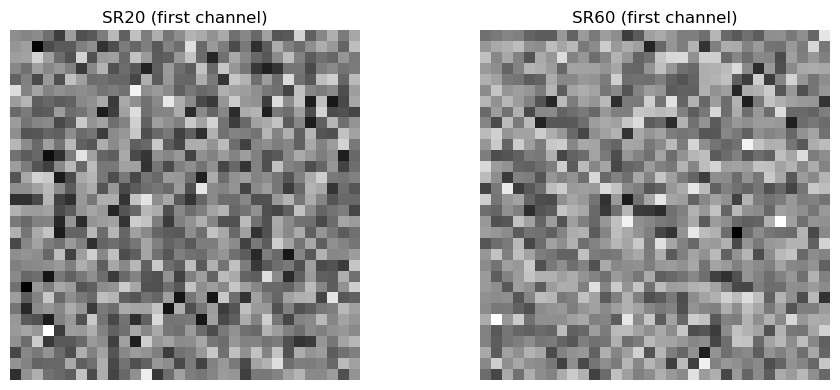

In [36]:

#print(model)
# Dummy input tensors
im10 = torch.randn(1, 4, 32, 32)       # HR bands at 10m
im20 = torch.randn(1, 6, 32, 32)        # 20m bands
im60 = torch.randn(1, 2, 32, 32)        # 60m bands

print(f"im10 shape: {im10.shape}")
print(f"im20 shape: {im20.shape}")
print(f"target20 shape: {im60.shape}")

sr20, sr60 = model(im10, im20, im60)
print(sr20.shape, sr60.shape)  # Expect [1, 6, 60, 60] and [1, 2, 60, 60]

# Plot the first channel of sr20 and sr60 as images
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("SR20 (first channel)")
plt.imshow(sr20[0, 0].detach().cpu().numpy(), cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("SR60 (first channel)")
plt.imshow(sr60[0, 0].detach().cpu().numpy(), cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


### DATALOADER

In [12]:
dataset20 = Sentinel2Dataset(dataset_type="20train")
print(f"Dataset length: {len(dataset20)}")

🔍 Detected local environment
Loading 20train data from ../data/train
Found 1 samples
Normalizing images...
Normalization complete.
Dataset length: 8000


im10 shape: torch.Size([4, 32, 32])
im20 shape: torch.Size([6, 32, 32])
im60 shape: torch.Size([0])
target20 shape: torch.Size([6, 32, 32])
im60 shape: torch.Size([0])
target60 shape: torch.Size([0])


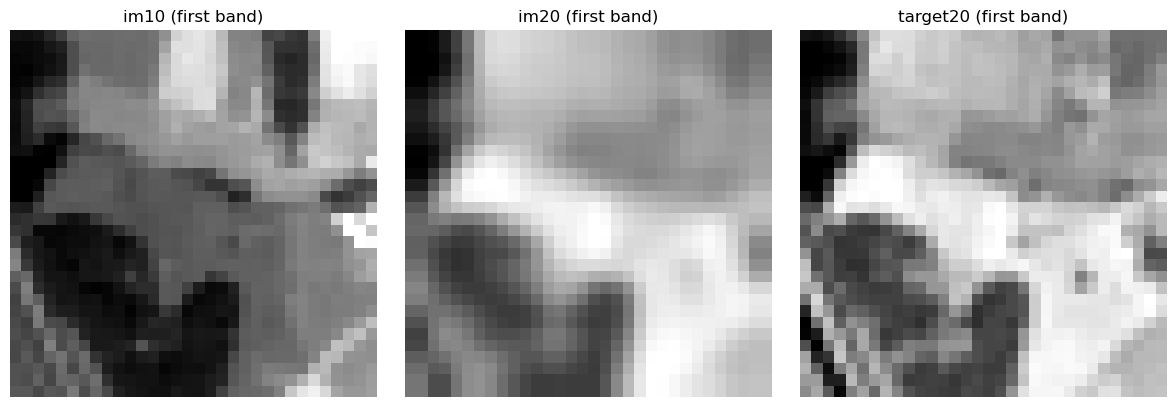

In [14]:


im10, im20, im60, target20, target60 = dataset20[0]
print(f"im10 shape: {im10.shape}")
print(f"im20 shape: {im20.shape}")
print(f"im60 shape: {im60.shape}")
print(f"target20 shape: {target20.shape}")
print(f"im60 shape: {im60.shape}")
print(f"target60 shape: {target60.shape}")

# Plot one image from each dataset tuple to check data is correctly loaded
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("im10 (first band)")
plt.imshow(im10[1].cpu().numpy(), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("im20 (first band)")
plt.imshow(im20[1].cpu().numpy(), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("target20 (first band)")
plt.imshow(target20[1].cpu().numpy(), cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


In [15]:
dataset60 = Sentinel2Dataset(dataset_type="60train")
print(f"Dataset length: {len(dataset60)}")

🔍 Detected local environment
Loading 60train data from ../data/train60
Found 1 samples
Normalizing images...
Normalization complete.
Dataset length: 500


im10 shape: torch.Size([4, 96, 96])
im20 shape: torch.Size([6, 96, 96])
target20 shape: torch.Size([0])
im60 shape: torch.Size([2, 96, 96])
target60 shape: torch.Size([2, 96, 96])


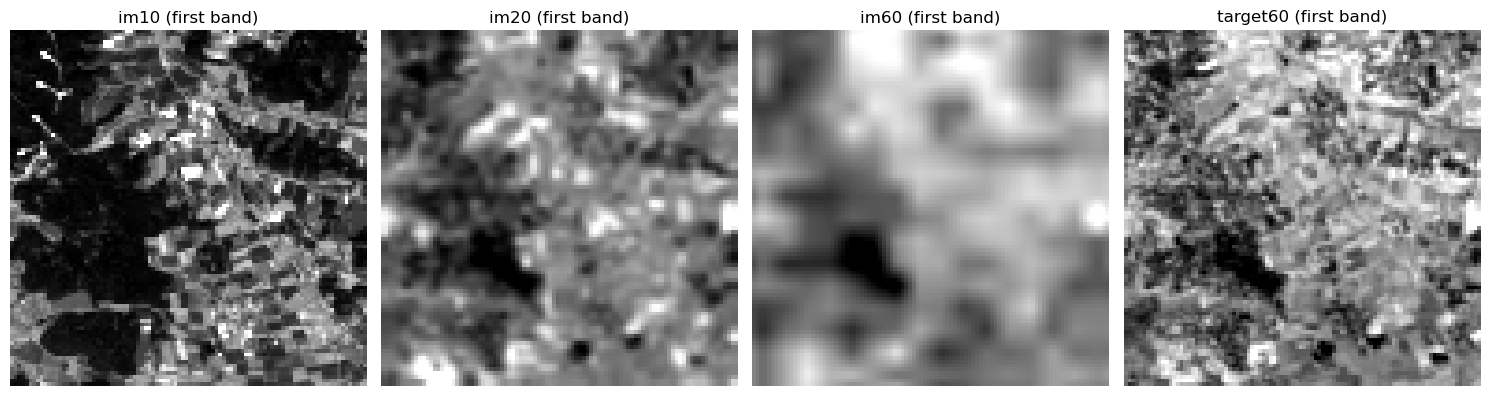

In [16]:
# Print shapes of im10, im20, target20, im60, target60

im10, im20, im60, target20, target60 = dataset60[0]
print(f"im10 shape: {im10.shape}")
print(f"im20 shape: {im20.shape}")
print(f"target20 shape: {target20.shape}")
print(f"im60 shape: {im60.shape}")
print(f"target60 shape: {target60.shape}")

# Plot one image from each dataset tuple to check data is correctly loaded
plt.figure(figsize=(15, 4))

plt.subplot(1, 4, 1)
plt.title("im10 (first band)")
plt.imshow(im10[1].cpu().numpy(), cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title("im20 (first band)")
plt.imshow(im20[1].cpu().numpy(), cmap='gray')
plt.axis('off')


plt.subplot(1, 4, 3)
plt.title("im60 (first band)")
if im60.numel() > 0:
    plt.imshow(im60[1].cpu().numpy(), cmap='gray')
else:
    plt.text(0.5, 0.5, "Empty", ha='center', va='center')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title("target60 (first band)")
if target60.numel() > 0:
    plt.imshow(target60[1].cpu().numpy(), cmap='gray')
else:
    plt.text(0.5, 0.5, "Empty", ha='center', va='center')
plt.axis('off')

plt.tight_layout()
plt.show()

In [37]:
testimages = Sentinel2DatasetTest(dataset_type="test60")
print(f"Dataset length: {len(testimages)}")

Loading test60 data from ../data/test60
Found 1 samples
Normalizing images...
Normalization complete.
Dataset length: 121


im10 tensor shape: torch.Size([4, 192, 192])
im20 tensor shape: torch.Size([6, 192, 192])
im60 tensor shape: torch.Size([2, 192, 192])


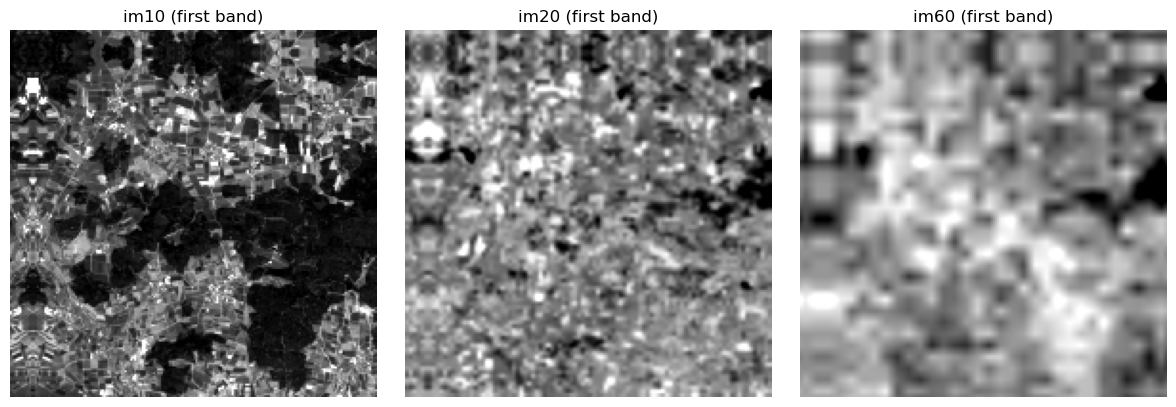

torch.Size([1, 6, 192, 192]) torch.Size([1, 2, 192, 192])


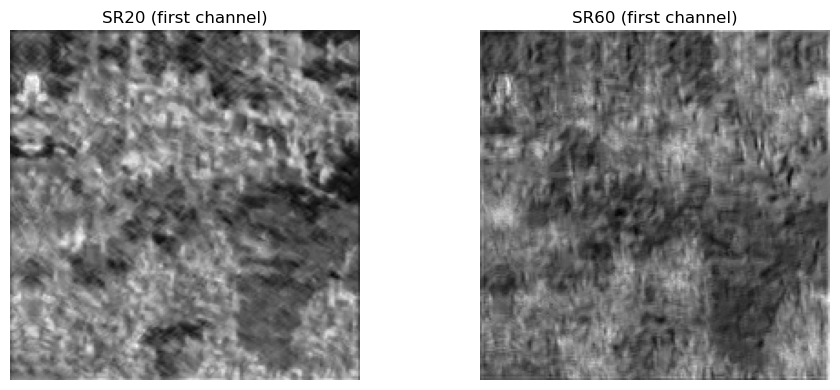

In [38]:
im10, im20, im60 = testimages[0]

# Convert to torch tensors (if not already)
im10 = torch.tensor(im10) if not isinstance(im10, torch.Tensor) else im10
im20 = torch.tensor(im20) if not isinstance(im20, torch.Tensor) else im20
im60 = torch.tensor(im60) if not isinstance(im60, torch.Tensor) else im60

print(f"im10 tensor shape: {im10.shape}")
print(f"im20 tensor shape: {im20.shape}")
print(f"im60 tensor shape: {im60.shape}")

# Plot one image from each dataset tuple to check data is correctly loaded
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("im10 (first band)")
plt.imshow(im10[1].cpu().numpy(), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("im20 (first band)")
plt.imshow(im20[1].cpu().numpy(), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("im60 (first band)")
plt.imshow(im60[1].cpu().numpy(), cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

# Insert the image into the model (assuming 'model' is defined and on the correct device)
# Add batch dimension
im10_batch = im10.unsqueeze(0)
im20_batch = im20.unsqueeze(0)
im60_batch = im60.unsqueeze(0)

# Move to device if needed (assuming model.device or 'cuda' if available)
device = next(model.parameters()).device if hasattr(model, 'parameters') else 'cpu'
im10_batch = im10_batch.to(device)
im20_batch = im20_batch.to(device)
im60_batch = im60_batch.to(device)

# Forward pass through the model
with torch.no_grad():
    sr20, sr60 = model(im10_batch, im20_batch, im60_batch)

    print(sr20.shape, sr60.shape)  # Expect [1, 6, 60, 60] and [1, 2, 60, 60]

    # Plot the first channel of sr20 and sr60 as images
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.title("SR20 (first channel)")
    plt.imshow(sr20[0, 0].detach().cpu().numpy(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("SR60 (first channel)")
    plt.imshow(sr60[0, 0].detach().cpu().numpy(), cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# Loss (L1)
# -------------------
loss_fn = nn.L1Loss()

# -------------------
# Training function that only saves the best model and computes metrics
# Now supports optional scheduler (e.g., CosineAnnealingLR)
# -------------------


def compute_rmse(pred, target):
    return torch.sqrt(torch.mean((pred - target) ** 2)).item()

def compute_sre(pred, target):
    # SRE = 10 * log10(mean(target^2) / mean((target-pred)^2) * N)
    mse = torch.mean((target - pred) ** 2)
    mean_signal = torch.mean(target ** 2)
    N = target.numel()
    if mse.item() == 0:
        return float('inf')
    return 10 * torch.log10((mean_signal * N) / (mse * N)).item()

def compute_sam(pred, target):
    # pred, target: [B, C, H, W]
    # Compute per-pixel spectral angle, then mean over all pixels
    pred_flat = pred.permute(0, 2, 3, 1).reshape(-1, pred.shape[1])
    target_flat = target.permute(0, 2, 3, 1).reshape(-1, target.shape[1])
    dot = (pred_flat * target_flat).sum(dim=1)
    norm_pred = torch.norm(pred_flat, dim=1)
    norm_target = torch.norm(target_flat, dim=1)
    cos_sim = dot / (norm_pred * norm_target + 1e-8)
    cos_sim = torch.clamp(cos_sim, -1, 1)
    angles = torch.acos(cos_sim)
    return torch.mean(angles).item() * 180 / np.pi  # degrees

def compute_psnr(pred, target):
    # pred, target: [B, C, H, W], values in [0,1]
    pred_np = pred.detach().cpu().numpy()
    target_np = target.detach().cpu().numpy()
    psnr_vals = []
    for b in range(pred_np.shape[0]):
        val = 0
        for c in range(pred_np.shape[1]):
            val += psnr_skimage(target_np[b, c], pred_np[b, c], data_range=1.0)
        psnr_vals.append(val / pred_np.shape[1])
    return np.mean(psnr_vals)

def compute_ssim(pred, target):
    # pred, target: [B, C, H, W], values in [0,1]
    pred_np = pred.detach().cpu().numpy()
    target_np = target.detach().cpu().numpy()
    ssim_vals = []
    for b in range(pred_np.shape[0]):
        val = 0
        for c in range(pred_np.shape[1]):
            val += ssim_skimage(target_np[b, c], pred_np[b, c], data_range=1.0)
        ssim_vals.append(val / pred_np.shape[1])
    return np.mean(ssim_vals)

def compute_ergas(pred, target, scale=6):
    # pred, target: [B, C, H, W], values in [0,1]
    # ERGAS = 100/d * sqrt(1/N * sum_c (RMSE_c / mean_c)^2)
    # d: ratio of spatial resolution (e.g., 6 for 10m->60m)
    pred_np = pred.detach().cpu().numpy()
    target_np = target.detach().cpu().numpy()
    B, C, H, W = pred_np.shape
    ergas_vals = []
    for b in range(B):
        sum_c = 0
        for c in range(C):
            rmse_c = np.sqrt(np.mean((pred_np[b, c] - target_np[b, c]) ** 2))
            mean_c = np.mean(target_np[b, c])
            if mean_c == 0:
                continue
            sum_c += (rmse_c / mean_c) ** 2
        if C > 0:
            ergas = 100 / scale * np.sqrt(sum_c / C)
            ergas_vals.append(ergas)
    return np.mean(ergas_vals) if len(ergas_vals) > 0 else float('nan')

def train_with_saving(
    model, 
    train_loader, 
    val_loader, 
    optimizer, 
    stage='sr20', 
    device='cuda', 
    patience=3, 
    save_dir='../models/',
    scheduler=None,  # <-- Add scheduler argument
    grad_clip=1.0    # <-- Add gradient clipping argument (default 1.0)
):
    import platform

    # Detect if running in Google Colab
    def is_colab():
        try:
            import google.colab
            return True
        except ImportError:
            return False

    # If running in Colab, override save_dir
    if is_colab():
        colab_save_dir = "/content/drive/MyDrive/Colab Notebooks/Super-Resolution of Sentinel-2 Low Resolution/models"
        print(f"Detected Google Colab environment. Saving models to: {colab_save_dir}")
        save_dir = colab_save_dir

    # Check if running on Mac and adapt device accordingly
    if platform.system() == 'Darwin':
        # On Mac, prefer 'mps' if available, else fallback to 'cpu'
        if torch.backends.mps.is_available():
            device = 'mps'
            print("Using Apple MPS device.")
        else:
            device = 'cpu'
            print("Apple MPS not available. Using CPU.")
    elif device == 'cuda' and not torch.cuda.is_available():
        print("CUDA is not available. Switching to CPU.")
        device = 'cpu'

    # Create save directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Use a fixed model name without datetime
    best_model_path = f"{save_dir}/best_{stage}_model.pth"

    model = model.to(device)
    if stage == 'sr20':
        model.freeze_sr60()
        model.unfreeze_sr20()
    elif stage == 'sr60':
        model.freeze_sr20()
        model.unfreeze_sr60()

    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(1, 101):
        model.train()
        total_loss = 0
        num_batches = len(train_loader)
        for batch_idx, (im10, im20, im60, target20, target60) in enumerate(train_loader, 1):
            im10, im20, im60 = im10.to(device), im20.to(device), im60.to(device)
            target20, target60 = target20.to(device), target60.to(device)

            sr20, sr60 = model(im10, im20, im60)
            loss = loss_fn(sr20, target20) if stage == 'sr20' else loss_fn(sr60, target60)
            optimizer.zero_grad()
            loss.backward()
            # --------- Gradient Clipping ---------
            if grad_clip is not None and grad_clip > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            # -------------------------------------
            optimizer.step()
            total_loss += loss.item()

            # Print echo completion rate
            completion_rate = 100.0 * batch_idx / num_batches
            print(f"\rEpoch {epoch:02d} | Batch {batch_idx}/{num_batches} ({completion_rate:.1f}%)", end='')

        # Step the scheduler every 10 epochs if provided
        if scheduler is not None and epoch % 10 == 0:
            scheduler.step()
            print(f"\nScheduler stepped at epoch {epoch}. Current LR: {scheduler.get_last_lr()}")

        print()  # Newline after epoch's batch progress

        val_loss = 0
        # For metrics
        all_preds = []
        all_targets = []

        model.eval()
        with torch.no_grad():
            for im10, im20, im60, target20, target60 in val_loader:
                im10, im20, im60 = im10.to(device), im20.to(device), im60.to(device)
                target20, target60 = target20.to(device), target60.to(device)

                sr20, sr60 = model(im10, im20, im60)
                if stage == 'sr20':
                    pred = sr20
                    target = target20
                else:
                    pred = sr60
                    target = target60

                loss = loss_fn(pred, target)
                val_loss += loss.item()

                # Only accumulate if target is not empty
                if target.numel() > 0 and pred.numel() > 0:
                    all_preds.append(pred.detach().cpu())
                    all_targets.append(target.detach().cpu())

        avg_train_loss = total_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        # Compute metrics
        if len(all_preds) > 0:
            preds = torch.cat(all_preds, dim=0)
            targets = torch.cat(all_targets, dim=0)
            # Clamp to [0,1] for metrics
            preds = torch.clamp(preds, 0, 1)
            targets = torch.clamp(targets, 0, 1)

            rmse = compute_rmse(preds, targets)
            sre = compute_sre(preds, targets)
            sam = compute_sam(preds, targets)
            psnr = compute_psnr(preds, targets)
            ssim = compute_ssim(preds, targets)
            # ERGAS scale: 6 for 10m->60m, 3 for 20m->60m, 2 for 10m->20m, etc.
            if stage == 'sr20':
                ergas_scale = 2  # 10m->20m
            else:
                ergas_scale = 3  # 20m->60m
            ergas = compute_ergas(preds, targets, scale=ergas_scale)
        else:
            rmse = sre = sam = psnr = ssim = ergas = float('nan')

        print(f"Epoch {epoch:02d} | Stage: {stage} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        print(f"  Metrics: RMSE={rmse:.4f} | SRE={sre:.2f} dB | SAM={sam:.2f} deg | PSNR={psnr:.2f} dB | SSIM={ssim:.4f} | ERGAS={ergas:.2f}")

        # Save best model if validation loss improves
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            epochs_no_improve = 0

            # Save the best model
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_loss': best_loss,
                'stage': stage
            }
            torch.save(checkpoint, best_model_path)
            print(f"✅ Best model saved at epoch {epoch} with val_loss: {avg_val_loss:.4f}")

        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch} epochs.")
                break

    print(f"⭐ Best {stage} model saved: {best_model_path} (val_loss: {best_loss:.4f})")

    return best_model_path


In [ ]:
    # Stage 1: Train SR20
dataset = dataset20
train_len = int(0.9 * len(dataset))
val_len = len(dataset) - train_len
train_set, val_set = random_split(dataset, [train_len, val_len])

train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
val_loader = DataLoader(val_set, batch_size=8, shuffle=False)

In [ ]:
 # Stage 1: Train SR20
optimizer1 = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-4)
# Add Cosine Annealing LR scheduler
scheduler1 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer1, T_max=20, eta_min=1e-6)
# Pass scheduler to train if supported, or step manually in your training loop
train(model, train_loader, val_loader, optimizer1, stage='sr20')

Using Apple MPS device.
Epoch 01 | Batch 6/900 (0.7%)

KeyboardInterrupt: 

In [ ]:
# Helper function to load saved models
def load_model(checkpoint_path, model=None):
    """
    Load a saved model from checkpoint
    
    Args:
        checkpoint_path (str): Path to the saved model checkpoint
        model (nn.Module, optional): Model instance to load weights into. If None, creates new Sen2RDSR model
    
    Returns:
        model: Loaded model
        checkpoint: Full checkpoint data including training info
    """
    if model is None:
        model = Sen2RDSR()
    
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])
    
    print(f"✅ Model loaded from: {checkpoint_path}")
    print(f"📊 Model info:")
    print(f"   - Stage: {checkpoint.get('stage', 'unknown')}")
    print(f"   - Epoch: {checkpoint.get('epoch', 'unknown')}")
    print(f"   - Best Loss: {checkpoint.get('best_loss', checkpoint.get('final_val_loss', 'unknown'))}")
    print(f"   - Timestamp: {checkpoint.get('timestamp', 'unknown')}")
    
    return model, checkpoint

# Example usage for training with model saving:
print("🚀 Usage Examples:")
print("\n1. Train with model saving:")
print("   best_path, final_path = train_with_saving(model, train_loader, val_loader, optimizer, stage='sr20')")
print("\n2. Load a saved model:")
print("   model, checkpoint = load_model('path/to/your/saved/model.pth')")
print("\n3. Resume training from checkpoint:")
print("   model, checkpoint = load_model('path/to/checkpoint.pth')")
print("   optimizer.load_state_dict(checkpoint['optimizer_state_dict'])")
print("\n📁 Models will be saved to '../results/' directory by default")
print("💡 You can change the save directory by passing save_dir parameter")


In [ ]:
# Updated training code with model saving
# Replace your previous training calls with these:

# Stage 1: Train SR20 with model saving
print("🎯 Starting SR20 training with model saving...")
optimizer1 = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-4)
best_sr20_path, final_sr20_path = train_with_saving(model, train_loader, val_loader, optimizer1, stage='sr20', save_dir='../results/')

print(f"\n✅ SR20 training completed!")
print(f"📁 Best SR20 model saved at: {best_sr20_path}")
print(f"📁 Final SR20 model saved at: {final_sr20_path}")

# Stage 2: Train SR60 with model saving
print("\n🎯 Starting SR60 training with model saving...")
# Load 60train dataset for SR60 training
dataset60 = Sentinel2Dataset(dataset_type="60train")
train_len60 = int(0.9 * len(dataset60))
val_len60 = len(dataset60) - train_len60
train_set60, val_set60 = random_split(dataset60, [train_len60, val_len60])

train_loader60 = DataLoader(train_set60, batch_size=8, shuffle=True)
val_loader60 = DataLoader(val_set60, batch_size=8, shuffle=False)

optimizer2 = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-4)
best_sr60_path, final_sr60_path = train_with_saving(model, train_loader60, val_loader60, optimizer2, stage='sr60', save_dir='../results/')

print(f"\n✅ SR60 training completed!")
print(f"📁 Best SR60 model saved at: {best_sr60_path}")
print(f"📁 Final SR60 model saved at: {final_sr60_path}")

print("\n🎉 Training completed! All models have been saved!")
print("\n📋 Summary of saved models:")
print(f"   - Best SR20 model: {best_sr20_path}")
print(f"   - Final SR20 model: {final_sr20_path}")
print(f"   - Best SR60 model: {best_sr60_path}")
print(f"   - Final SR60 model: {final_sr60_path}")

# Note: Comment out the above training code if you just want to define the functions
# and run training manually. Uncomment and run when you're ready to train!
